In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm.autonotebook import tqdm

In [194]:
class B_Splines:

    def __init__(self, knots, order):

        # Parameters
        self.knots = knots
        self.order = order
        self.num_basis = len(self.knots) - 1 - self.order

        # Basis functions
        self.supports = self.__supports()
        self.evaluations = self.__evaluations()

    # Basis function features
    
    def __supports(self):
        supports = []
        for i in range(len(self.knots) - 1 - self.order):
            supports.append((i, i+self.order+1))
        return supports

    def __evaluations(self):
        evals = []
        for i in range(len(self.knots) -1 - self.order):
            i_b = self.order + i
            i_a = i_b - (2*self.order)

            evals.append((max(0,i_a), min(i_b,self.num_basis-1)))
        return evals


    # Generating basis functions

    def __basis_0(self, x):
        return np.where(np.all([self.knots[:-1] <=  x, x < self.knots[1:]],axis=0), 1.0, 0.0)

    def __basis_p(self, x, p):

        if p == 0:
            return self.__basis_0(x)
        
        else:
            basis_p_minus_1 = self.__basis_p(x, p - 1)

        term_1_num = x - self.knots[:-p]
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = self.knots[(p+1):] - x
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * basis_p_minus_1[:-1] + second_term * basis_p_minus_1[1:])

    def generate_basis_p(self):

        X = np.linspace(min(self.knots), max(self.knots), 200)
        basis = []

        for x in X:
            basis.append(self.__basis_p(x, self.order))

        return X, np.array(basis)

    # Generating derivatives of basis functions

    def __grad_basis_p(self, x, p):

        if p == 0:
            raise ValueError('Order must be > 0')

        basis_p_minus_1 = self.__basis_p(x, p - 1)

        term_1_num = p
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = -p
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * basis_p_minus_1[:-1] + second_term * basis_p_minus_1[1:])


    def __grad_m_basis_p(self, x, p, m):

        if m == 1:
            return self.__grad_basis_p(x, p) 

        else:
            grad_basis_p_minus_1 = self.__grad_m_basis_p(x, p-1, m-1)


        term_1_num = p
        term_1_den = self.knots[p:] - self.knots[:-p]

        term_2_num = -p
        term_2_den = self.knots[(p+1):] - self.knots[1:-p]

        with np.errstate(divide='ignore', invalid='ignore'):
            term_1 = np.where(term_1_den != 0.0,
            )

        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(term_1_den != 0.0,
                                  (term_1_num /
                                   term_1_den), 0.0)
            second_term = np.where(term_2_den != 0.0,
                                   (term_2_num /
                                    term_2_den), 0.0)

        return (first_term[:-1] * grad_basis_p_minus_1[:-1] + second_term * grad_basis_p_minus_1[1:])


    def generate_grad_basis_p(self, m):

        X = np.linspace(min(self.knots), max(self.knots), 200)
        grad_basis = []

        for x in X:
            grad_basis.append(self.__grad_m_basis_p(x, self.order, m))

        return X, np.array(grad_basis)

    # Integration

    def basis_product(self, x, basis_1, basis_2):
        return self.__basis_p(x, self.order)[basis_1] * self.__basis_p(x, self.order)[basis_2]

    def grad_basis_product(self, x, m, basis_1, basis_2):
        return self.__grad_m_basis_p(x, self.order, m)[basis_1] * self.__grad_m_basis_p(x, self.order, m)[basis_2]

    def gauss_quadrature(self, basis_1, basis_2):

        a = max(self.supports[basis_1][0], self.supports[basis_2][0])
        b = min(self.supports[basis_1][1], self.supports[basis_2][1])

        if a < b:
            knots_subset = [k for k in self.knots if k >= a and k <= b]
            integral = 0
            for i in range(len(knots_subset)-1):
                integral += integrate.quad(self.basis_product, knots_subset[i], knots_subset[i+1], args=(basis_1, basis_2))[0]
            return integral

        else:
            return 0

    def grad_gauss_quadrature(self, m, basis_1, basis_2):
        integral = 0
        for i in range(len(self.knots)-1):
            integral += integrate.quad(self.grad_basis_product, self.knots[i], self.knots[i+1], args=(m, basis_1, basis_2))[0]
        return integral

    # RKHS Inner product

    def RKHS_IP_gauss(self, basis_1, basis_2, l, sigma):

        integral_1 = self.gauss_quadrature(basis_1, basis_2)
        integral_2 = self.grad_gauss_quadrature(1, basis_1, basis_2)

        term_1 = (l/(2*sigma**2)) * integral_1
        term_2 = (1/(2*l*sigma**2)) * integral_2

        _basis_a = self.__basis_p(min(self.knots), self.order)
        _basis_b = self.__basis_p(max(self.knots), self.order)

        term_3 = (1/(2*sigma**2)) * ( (_basis_a[basis_1] * _basis_a[basis_2]) + (_basis_b[basis_1] * _basis_b[basis_2]) )

        return term_1 + term_2 + term_3

    def gram_matrix_gauss(self, l, sigma):
        n = len(self.knots) - 1 - self.order
        G = np.zeros((n,n))
        for i in range(n):
            i_left = self.evaluations[i][0]
            i_right = self.evaluations[i][1]
            for j in range(i_left, i_right+1):
                G[i,j] = self.RKHS_IP_gauss(i, j, l, sigma)
        return G

    # Inner product

    def RKHS_IP(self, basis_1, basis_2, l, sigma):

        a = min(self.knots)
        b = max(self.knots)

        X = np.linspace(a, b, 500)

        integrand_1 = []
        integrand_2 = []

        for x in X:
            _grad_basis = self.__grad_basis_p(x, self.order)
            _basis = self.__basis_p(x, self.order)

            integrand_1.append(_grad_basis[basis_1] * _grad_basis[basis_2])
            integrand_2.append(_basis[basis_1] * _basis[basis_2])

        integral_1 = integrate.simpson(integrand_1, X)
        integral_2 = integrate.simpson(integrand_2, X)

        term_1 = (l/(2*sigma**2)) * integral_1
        term_2 = (1/(2*l*sigma**2)) * integral_2

        _basis_a = self.__basis_p(a, self.order)
        _basis_b = self.__basis_p(b, self.order)

        term_3 = (1/(2*sigma**2)) * ( (_basis_a[basis_1] * _basis_a[basis_2]) + (_basis_b[basis_1] * _basis_b[basis_2]) )

        return term_1 + term_2 + term_3


    def gram_matrix(self, l, sigma):

        n = len(self.knots) - 1 - self.order

        G = np.zeros((n,n))

        for i in range(n):
            for j in range(n):
                G[i,j] = self.RKHS_IP(i, j, l, sigma)

        return G

In [204]:
knots = np.linspace(0,10,40)
p = 3
BS = B_Splines(knots, p)


In [205]:
i = 1
print(BS.gauss_quadrature(0, i))
print(BS.grad_gauss_quadrature(1,0,i))

0.0
-0.48750000000000004


In [206]:
G = BS.gram_matrix_gauss(1,1)
#np.all(np.linalg.eigvals(G) > 0)
np.diag(G)

array([1.36145706, 1.30050875, 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       , 1.3       , 1.3       , 1.3       , 1.3       ,
       1.3       ])

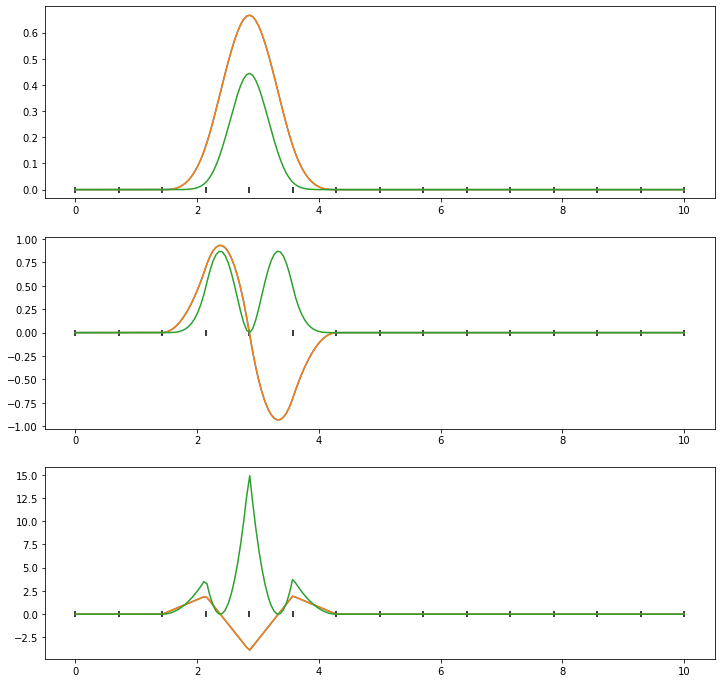

In [150]:
x, basis = BS.generate_basis_p()
x, grad_basis_1 = BS.generate_grad_basis_p(1)
x, grad_basis_2 = BS.generate_grad_basis_p(2)

# for i in range(len(knots)-p-1):
#     plt.plot(x, basis[:,i])

fig = plt.figure(figsize=(12,12))

i = 2
j = 2

ax1 = plt.subplot(311)
ax1.plot(x, basis[:,i])
ax1.plot(x, basis[:,j])
ax1.plot(x, np.multiply(basis[:,i], basis[:,j]))
ax1.scatter(knots, np.zeros(len(knots)), marker='|', color='black')
#ax1.plot(xs, i2)

ax2 = plt.subplot(312)
ax2.plot(x, grad_basis_1[:,i])
ax2.plot(x, grad_basis_1[:,j])
ax2.plot(x, np.multiply(grad_basis_1[:,j], grad_basis_1[:,i]))
ax2.scatter(knots, np.zeros(len(knots)), marker='|', color='black')
#ax2.plot(xs, i1)

ax3 = plt.subplot(313)
ax3.plot(x, grad_basis_2[:,i])
ax3.plot(x, grad_basis_2[:,j])
ax3.plot(x, np.multiply(grad_basis_2[:,i], grad_basis_2[:,j]))
ax3.scatter(knots, np.zeros(len(knots)), marker='|', color='black')


ValueError: x and y must have same first dimension, but have shapes (57,) and (56,)

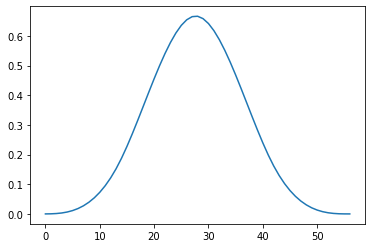

In [169]:
i = 1
j = 5

basis_i = basis[:,i][basis[:,i] != 0]
basis_j =basis[:,j][basis[:,j] != 0]

x = np.arange(len(basis_i))

plt.plot(x, basis_i)
plt.plot(x, basis_j)

